In [1]:
from __future__ import print_function, division
import torch
from PIL import Image
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision import transforms
from tensorflow.keras.applications.efficientnet import decode_predictions

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
cvmodel = model
cvmodel.eval()
feat_exp = create_feature_extractor(cvmodel, return_nodes=['avgpool'])
fc = model.fc
model.eval()
feat_exp.eval()
cvmodel.eval()

Using cache found in /Users/patrickknab/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/patrickknab/anaconda3/envs/dseg/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/patrickknab/anaconda3/envs/dseg/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
sam_checkpoint = "./Models/pretrained/sam_vit_h_4b8939.pth" # Adapt Path to SAM checkpoint

model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mask_generator = SamAutomaticMaskGenerator(sam,
                                           min_mask_region_area=512,
                                            points_per_side=32,
                                            )



/Users/patrickknab/anaconda3/envs/dseg/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(

In [4]:
test_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]) ### a complete imagenet data pre-process

image_reshape = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
]) ### process the imagenet data to sam

image_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]) ### imagenet std and mean

class ImageModel:
    def __init__(self, model, test_preprocess):
        self.model = model
        self.test_preprocess = test_preprocess
        
    def predict (self, image_data):
        first_dim = 1 if len(image_data.shape) == 3 else len(image_data)
        image_data = image_data.reshape(first_dim, image_data.shape[1], image_data.shape[2], 3)
        
        # Convert numpy array to PIL Images
        image_data_pil = [Image.fromarray(local_img) for local_img in image_data]
        # Apply preprocessing
        preprocessed_images = [test_preprocess(img).unsqueeze(0) for img in image_data_pil]
        
        # Stack preprocessed images into a batch tensor
        batch_tensor = torch.cat(preprocessed_images, dim=0)
        
        # Pass the batch tensor through the model
        scores = self.model(batch_tensor)
        return scores
    
image_model = ImageModel(model, test_preprocess)
def lime_explanation_function(images):
    scores = image_model.predict(images)
    scores_np = scores.detach().numpy()
    return scores_np

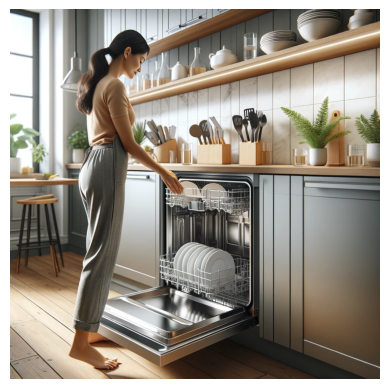

torch.Size([1, 1000])

In [9]:
img_path = "./Dataset/Evaluation/Dishwasher_woman.png"
"""
Info: We generated two images, dishwasher with a man, with a women and without, to test the model on gender bias.
"""

img = Image.open(img_path).convert('RGB')

plt.imshow(img)
plt.axis(False)
plt.show()
plt.close()

predict_org = torch.nn.functional.softmax(model(test_preprocess(img).unsqueeze(0)),dim=1)
predict_org.shape



In [6]:
arg_position = 1
pred_image_class = torch.sort(predict_org, descending=True).indices[0][arg_position].item()
label_class = decode_predictions(predict_org.detach().numpy().reshape(1, -1))
print(label_class)
print(pred_image_class)

[[('n02480855', 'gorilla', 0.86222017), ('n02486410', 'baboon', 0.07067107), ('n02488291', 'langur', 0.01956317), ('n02483362', 'gibbon', 0.01885447), ('n02487347', 'macaque', 0.011691788)]]
372


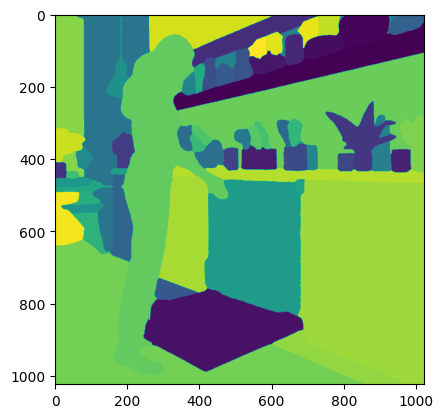

100%|██████████| 256/256 [00:18<00:00, 14.15it/s]


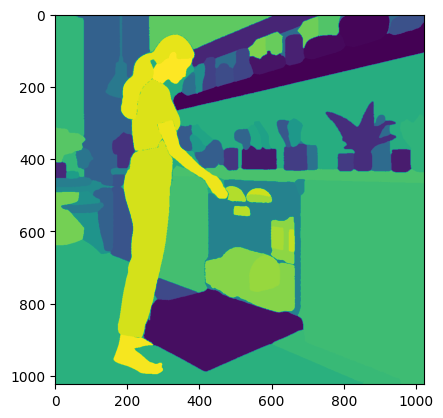

100%|██████████| 256/256 [00:18<00:00, 13.81it/s]


In [10]:
from Utilities.dseg_lime import DSEG_Lime

explainer = DSEG_Lime()
img = Image.open(img_path).convert('RGB')
for_mask_image = np.array((img)) 
explanation = explainer.explain_instance(image = for_mask_image, 
                                        classifier_fn=lime_explanation_function,
                                        feature_extractor=mask_generator,
                                        model = sam,
                                        image_path = img_path,
                                        iterations = 2)


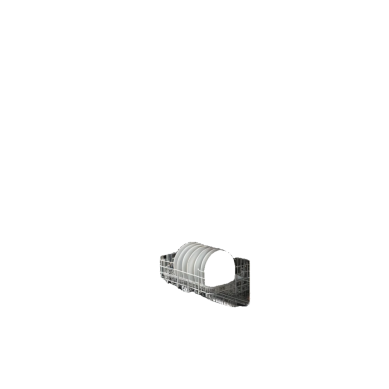

In [11]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1, hide_rest=True)
# Convert mask to 3D
mask_3d = np.stack([mask] * 3, axis=-1)
# Create a white background image
white_background = np.ones_like(np.array(for_mask_image)) * 255 
# Blend the original image with the white background using the mask
image_with_mask = np.where(mask_3d, np.array(for_mask_image), white_background)
# Display the image with boundaries
plt.imshow(image_with_mask)
plt.axis(False)
plt.show()